# Example: Registered Interest and Principal of Securities (STRIPS) Bonds
This example will familiarize students with the ideas behind [Registered Interest and Principal of Securities (STRIPS)](https://www.treasurydirect.gov/marketable-securities/strips/) bonds from the perspective of the issuer.

Fill me in.

Let's go!
___


## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 

> __Include:__ The [include(...) function](https://docs.julialang.org/en/v1/base/base/#include) is a convenient way to load Julia code from another file. The `Include.jl` file is a Julia file that loads external packages, and various functions that we will use in the exercise. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Otherwise, packages are downloaded and then loaded.

Setup the environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # this sets up the environment, we'll do this all the time, on everything we do

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We'll explore `T-note` and `T-bond` prices from United States Treasury auctions between October 2022 and August 2023 downloaded as a `CSV` file using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). 

> __Dataset:__ We load the `CSV` dataset using [the local `MyTreasuryNotesAndBondsDataSet()` function](src/Files.jl), which returns the auction data as a `DataFrame`. We store the auction data in the `dataset::DataFrame` variable.

So what do we have?

In [2]:
dataset = MyTreasuryNotesAndBondsDataSet()

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,High Yield,Interest Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64,Float64
1,91282CHW4,Note,7-Year,08/29/2023,08/31/2023,08/31/2030,99.4773,0.04212,0.04125
2,91282CHV6,Note,2-Year,08/28/2023,08/31/2023,08/31/2025,99.9549,0.05024,0.05
3,91282CHX2,Note,5-Year,08/28/2023,08/31/2023,08/31/2028,99.8889,0.044,0.04375
4,912810TU2,Bond,20-Year,08/23/2023,08/31/2023,08/15/2043,98.3742,0.04499,0.04375
5,912810TT5,Bond,30-Year,08/10/2023,08/15/2023,08/15/2053,98.9127,0.04189,0.04125
6,91282CHT1,Note,10-Year,08/09/2023,08/15/2023,08/15/2033,98.9862,0.03999,0.03875
7,91282CHU8,Note,3-Year,08/08/2023,08/15/2023,08/15/2026,99.936,0.04398,0.04375
8,91282CHR5,Note,7-Year,07/27/2023,07/31/2023,07/31/2030,99.475,0.04087,0.04
9,91282CHQ7,Note,5-Year,07/25/2023,07/31/2023,07/31/2028,99.7988,0.0417,0.04125


___

## Task 1: Select a random note or bond from which we create separate marketable products
In this task, we'll select a random note or bond, compute its price, compare it to the auction price (to `check` our price codes), and then `strip` the selected note or bond.

First, let's determine how many notes and bonds we have in the `dataset::DataFrame` using the [nrow function](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.nrow) that is exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl). Then, we'll compute a random index using the [built-in Julia rand function](https://docs.julialang.org/en/v1/stdlib/Random/). We store the data for the random note or bond in the `random_note_or_bond` variable

In [3]:
random_note_or_bond_data = let
    
    # initialize -
    number_of_notes_and_bonds = nrow(dataset); # how many notes and bonds do we have?
    i = rand(1:number_of_notes_and_bonds); # pick a random index
    random_note_or_bond = dataset[i,:];
    random_note_or_bond # return
end


Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,High Yield,Interest Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64,Float64
42,91282CGK1,Note,10-Year,01/19/2023,01/31/2023,01/15/2033,99.0601,0.0122,0.01125


Get the parameters from `random_note_or_bond` variable to test our price calculation. 

> __Data we need:__ We set the face (par) value `Vₚ,` the duration `T` (which we convert to the number of years using [the `securityterm(...)` function](src/Utility.jl)), the yield field, i.e., the $\bar{r}$ value in the discount rate, the coupon rate $c$ and the number of coupon payments per year `λ`.

Let's gather that data, and stored it in the `random_note_of_bond_parameters::NamedTuple` variable.

In [4]:
random_note_of_bond_parameters = let
    
    Vₚ = 100.0; # face value of the note or bond
    T = random_note_or_bond_data[Symbol("Security Term")] |> String |> securityterm; # term as a Float64
    r̄ = random_note_or_bond_data[Symbol("High Yield")]; # Effective discount rate
    c̄ = random_note_or_bond_data[Symbol("Interest Rate")]; # Interest rate (coupon rate)
    λ = 2; # number of coupon payments per year

    # package -
    data = (Vₚ=Vₚ, T=T, r̄=r̄, c̄=c̄, λ=λ) # this is a NamedTuple - a cool data structure!

    data; # return
end

(Vₚ = 100.0, T = 10.0, r̄ = 0.0122, c̄ = 0.01125, λ = 2)

Next, we instantiate a discrete compounding model, and store this model in the `discrete_compounding` variable, and cpmpute the price of the random note or bond using the [the `VLQuantitativeFinancePackage.jl` bond pricing functionality](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/). We store the computed price in the `computed_price` variable.

Finally, we compare our computed price to the auction price, and then `strip` the selected note or bond using the [the `strip(...)` function](src/Bonds.jl). We store the stripped products in the `stripped_products::Vector{ZeroCouponBond}` variable.

In [5]:
nominal_bond_model = let

    # Build a discrete compounding model -
    discrete_compounding = DiscreteCompoundingModel();

    # unpack parameters -
    Vₚ = random_note_of_bond_parameters.Vₚ; # face value of the note or bond
    T = random_note_of_bond_parameters.T; # term as a Float64
    r̄ = random_note_of_bond_parameters.r̄; # Effective discount rate
    c̄ = random_note_of_bond_parameters.c̄; # Interest rate (coupon rate)
    λ = random_note_of_bond_parameters.λ; # number of coupon payments per year

    # Build a T-year model and compute the price using the short-hand syntax
    model = build(MyUSTreasuryCouponSecurityModel, (
            par = Vₚ, T = T, rate = r̄, coupon = c̄, λ = λ
    )) |> discrete_compounding;

    model; # return
end

MyUSTreasuryCouponSecurityModel(100.0, 0.0122, 0.01125, 10.0, 2, 99.10821833362596, Dict(5 => 0.5456532946119819, 16 => 0.5103453273461944, 20 => 89.04572647724369, 12 => 0.5229121570926119, 8 => 0.5357884345823772, 17 => 0.5072510956626523, 1 => 0.5590895537222941, 19 => 0.5011187996760683, 0 => -99.10821833362596, 6 => 0.5423449901719332…), Dict(5 => 1.0308743767413664, 16 => 1.1021948666112236, 20 => 1.1293354996177105, 12 => 1.0757064879261868, 8 => 1.049854688331306, 17 => 1.108918255297552, 1 => 1.0061, 19 => 1.1224883208604617, 0 => 1.0, 6 => 1.0371627104394887…))

### Check: Are the calculated and observed auction prices `similar`?
Use the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check the `similarity` of the computed, and observed note (or bond) price. If the price values are different beyond `rtol = 1e-3`, a `false` result is generated, and an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [6]:
let
    observed_bond_price = random_note_or_bond_data[:Price];
    @assert isapprox(observed_bond_price, nominal_bond_model.price; atol = 1e-4)
end

AssertionError: AssertionError: isapprox(observed_bond_price, nominal_bond_model.price; atol = 0.0001)

### Strip the note or bond to create a collection of zero-coupon payments
We generate a dictionary of zero-coupon bond models for a `MyUSTreasuryCouponSecurityModel` using [the `strip(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.strip) exported by the [`VLQuantitativeFinancePackage.jl package`](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) 

The resulting `strips::MyUSTreasuryZeroCouponBondModel` dictionary stores the generated bonds in order of duration, with their indexes serving as keys and the corresponding `MyUSTreasuryZeroCouponBondModel` instances as values. 

In [7]:
strips = VLQuantitativeFinancePackage.strip(nominal_bond_model)

Dict{Int64, MyUSTreasuryZeroCouponBondModel} with 21 entries:
  5  => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 2.5, nothing, 2, nothi…
  16 => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 8.0, nothing, 2, nothi…
  20 => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 10.0, nothing, 2, noth…
  12 => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 6.0, nothing, 2, nothi…
  8  => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 4.0, nothing, 2, nothi…
  17 => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 8.5, nothing, 2, nothi…
  1  => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 0.5, nothing, 2, nothi…
  19 => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 9.5, nothing, 2, nothi…
  6  => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 3.0, nothing, 2, nothi…
  11 => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 5.5, nothing, 2, nothi…
  9  => MyUSTreasuryZeroCouponBondModel(0.5625, nothing, 4.5, nothing, 2, nothi…
  14 => MyUSTreasuryZeroCouponBondModel(0.5625,

#### Check: Do we have the correct number of stripped products?
For a parent note or bond of duration `T` years, there should be $\lambda\;{T}+1$ STRIPS, where $\lambda$ is the number of coupon payments per year. Let's verify [that the `strip(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.strip    ) produced the correct number of products. 

> __Test:__ Use the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check the number of STRIPS. If the `incorrect` number of products is in the `strips` dictionary, a `false` result is generated, and an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown. Otherwise, the code runs without error.

What do we get?

In [8]:
let

    # unpack parameters -
    T = random_note_of_bond_parameters.T; # term as a Float64
    λ = random_note_of_bond_parameters.λ; # number of coupon payments per year

    number_of_strips = λ*T+1 |> Int # correct number of STRIPs
    @assert length(strips) == number_of_strips # soooo, I'm waiting!!!
end

## Task 2: Pricing the STRIPS products for secondary auction
STRIPS are sold at a discount compared to their face. However, it’s important to note that the secondary seller, i.e., the brokerage splitting the original note or bond, determines the (initial) discount in the secondary treasury market. To better understand this, let’s explore three hypothetical pricing schemes that a brokerage might employ:


> __Scheme 1 constant yield__: In this approach, the brokerage prices the zero-coupon instruments to have a constant yield $\bar{r}$. This can be achieved by setting the price as an escalating fraction of the par value $V_{B} = \left(\alpha\right)^{T}\cdot{V}_{P}$, where $\alpha\leq{1}$, and $T$ represent the time to maturity of the generated zero coupon bond.

> __Scheme 2 constant discount__: The brokerage prices the zero-coupon instruments to have a constant discount, i.e., the ratio of price to face value is constant across all instruments. In this case, $V_{B} = \left(\alpha\right)\cdot{V}_{P}$ is not a function of the time to maturity of the instrument, and $\alpha\leq{1}$.

> __Scheme 3:__ In this scheme, we allow the yield to vary with the maturity of the bond. Suppose the yield we are willing to sell the bond is given by:
> $$
\bar{r}_{i} = \theta_{1}+\theta_{2}\cdot\left(i-1\right)^{\beta}
> $$
> where $i$ denotes the STRIPS index, $\theta_{1}$ denotes the interest rate for the shortest term bond, $\theta_{2}$ governs how fast the rate escalates for each pass of the loop, i.e., for each bond of longer maturity that we sell, and $\beta$ is a sensitivity parameter. Because $\theta_{1}>{0}$, $\theta_{2}\geq{0}$, and $\beta>0$ this scheme will give a _normal_ yield curve $\bar{r}_{i}\leq\bar{r}_{i+1}$, i.e., longer-term maturity will have a higher-yield compared to shorter-term bonds.

Let's start with Scheme 1.

### Scheme 1: Constant yield STRIPS  
To start, let's specify a value for the escalation parameter $\alpha\leq{1}$:

In [9]:
α = 0.97; # must be less than 1

Next, for each `zero` in the `strips` dictionary, let's specify (or compute) the missing `price` and `rate` values. To compute the price value, we compute the discount `d` (which depends upon our choice of `scheme` and $\alpha$) and the `yield` using [the yieldtomaturity(...) function](src/Compute.jl) that we developed in class. 


In [10]:
strips = let

    strips = VLQuantitativeFinancePackage.strip(nominal_bond_model)
    number_of_strips = length(strips);
    for (k,v) ∈ strips

        # get data from this strip
        model = v;
        T = model.T # time to maturity
        Vₚ = model.par; # face value
        d = (α)^T; # we selected scheme 1
        model.price = (d)*Vₚ # set the price

        (ytm, ytm_estimates) = yieldtomaturity(model;
            TR = T,
            price = model.price,
            ϵ = 1e-10,
            maxiter = 1000,
        );
    
        # do a YTM calculation to compute the market rate of interest
        model.rate = ytm;
    end
    strips; # return
end

Dict{Int64, MyUSTreasuryZeroCouponBondModel} with 21 entries:
  5  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 2.5, 0.521257, 2, no…
  16 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 8.0, 0.440856, 2, no…
  20 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 10.0, 0.414801, 2, n…
  12 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 6.0, 0.468547, 2, no…
  8  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 4.0, 0.497977, 2, no…
  17 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 8.5, 0.434192, 2, no…
  1  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 0.5, 0.553998, 2, no…
  19 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 9.5, 0.421167, 2, no…
  6  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 3.0, 0.513379, 2, no…
  11 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 5.5, 0.475737, 2, no…
  9  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0304592, 4.5, 0.490451, 2, no…
  14 => MyUSTreasuryZeroCouponBondModel(0.5625,

#### Visualize the first $m$ STRIPS products
`Unhide` the next code cell to see how we build a table displaying the bond price information. 

First, specify the `number_of_strips_to_view.` Then, we'll loop through each STRIP and access the respective models from the `strips` dictionary using the bracket notation `strips[i],` where `i` represents the STRIP index. Next, we'll add pricing, maturity, etc. data to the `strips_table_data_array` and display the resulting table by calling the `pretty_table(…)` function, which is exported by the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [11]:
strips_table_data_array_S1 = let

    number_of_strips = length(strips);
    number_of_strips_to_view = number_of_strips ≥ 20 ? 10 : number_of_strips
    strips_table_data_array_S1 = Array{Any,2}(undef, number_of_strips, 6);
    strips_table_header_array = (["", "Maturity","Face","Price","Ȳ", "Discount"],
        ["","YR","USD","USD","", "price/face"]);
    for i ∈ 1:number_of_strips

        zc_model = strips[i];
        strips_table_data_array_S1[i,1] = i
        strips_table_data_array_S1[i,2] = zc_model.T
        strips_table_data_array_S1[i,3] = zc_model.par
        strips_table_data_array_S1[i,4] = zc_model.price
        strips_table_data_array_S1[i,5] = zc_model.rate  
        strips_table_data_array_S1[i,6] = (zc_model.price/zc_model.par)
    end
    pretty_table(strips_table_data_array_S1[1:number_of_strips_to_view,1:end], 
        header=strips_table_header_array, tf = tf_simple)

    strips_table_data_array_S1; # return
end;

===== ========== ======== ========== =========== =============
       Maturity     Face      Price           Ȳ     Discount 
             YR      USD        USD               price/face 
===== ========== ======== ========== =========== =============
   1        0.5   0.5625   0.553998   0.0304592     0.984886
   2        1.0   0.5625   0.545625   0.0304592         0.97
   3        1.5   0.5625   0.537378   0.0304592     0.955339
   4        2.0   0.5625   0.529256   0.0304592       0.9409
   5        2.5   0.5625   0.521257   0.0304592     0.926679
   6        3.0   0.5625   0.513379   0.0304592     0.912673
   7        3.5   0.5625   0.505619   0.0304592     0.898879
   8        4.0   0.5625   0.497977   0.0304592     0.885293
   9        4.5   0.5625   0.490451   0.0304592     0.871912
  10        5.0   0.5625   0.483038   0.0304592     0.858734
===== ========== ======== ========== =========== =============


#### Check: Visualize the yield curve for `scheme 1`
`Unhide` the next code cell to see how we plotted the yield curve suggested by your choice of the $\alpha$ parameter.

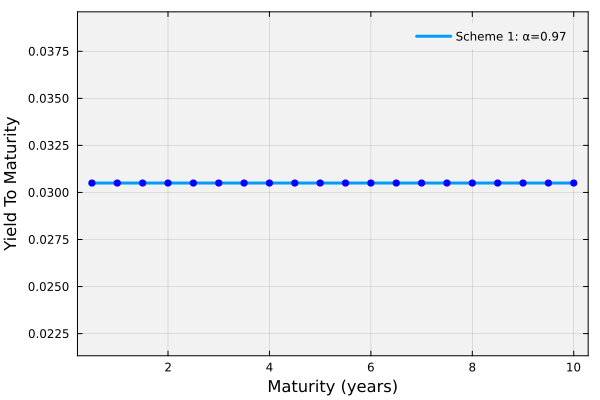

In [ ]:
let
    plot(strips_table_data_array_S1[1:end-1,2], round.(strips_table_data_array_S1[1:end-1,5], digits=4),lw=3,
        label="Scheme 1: α=$(α)", ylims=(0.70*strips_table_data_array_S1[1,5], 1.3*strips_table_data_array_S1[1,5]))
    scatter!(strips_table_data_array_S1[1:end-1,2], round.(strips_table_data_array_S1[1:end-1,5], digits=4), 
    label="", msc="blue", mc="blue")
    xlabel!("Maturity (years)",fontsize=18)
    ylabel!("Yield To Maturity (spot rate)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

#### Check: How much do we collect from the sale of the STRIPS?
In this scenario, we purchased an original instrument from the [United States Treasury](https://www.treasurydirect.gov/) for $V_{B}$, stripped the coupons and face, and resold them. How much did we make from the sale of the STRIPS?

In [13]:
let
    nominal_computed_price = nominal_bond_model.price;
    resale_total = sum(strips_table_data_array_S1[:,4]);
    println("Purchased bond for $(nominal_computed_price) USD and stripped it for $(resale_total) USD")
end

Purchased bond for 99.10821833362596 USD and stripped it for 83.36689719983063 USD


#### Summary Scheme 1 Pricing
* The constant yield (Scheme 1) pricing approach gives a constant yield curve and a decreasing discount. The short maturity `zeros` are more expensive relative to the face value of the original instrument.
* The observed yield $\bar{r}$ is inversely proportional to the value of the escalation parameter $\alpha$; smaller values of $\alpha$ lead to higher yields $\bar{r}$. On the other hand, $\alpha$ is directly proportional to the discount, i.e., the price of the `zero` relative to its face value
* The yield we collect from the U.S. Treasury is always greater than what we pay to holders of the STRIPS products. Thus, we pay for the original instrument under pricing scheme 1. However, would anyone buy these STRIPS?

### Scheme 2: Constant discount STRIPS
Now, let's consider scheme 2, which has a constant discount, i.e., the ratio of the auction price to the instrument's face value is constant. We'll use the same value of escalation parameter $\alpha$ and procedure as the previous Scheme 1 calculation, except we remove the time dependence on the `d` variable

In [14]:
strips = let

    strips = VLQuantitativeFinancePackage.strip(nominal_bond_model)
    number_of_strips = length(strips);
    for (k,v) ∈ strips

        # get data from this strip
        model = v;
        T = model.T # time to maturity
        Vₚ = model.par; # face value
        d = (α); # we selected scheme 1
        model.price = (d)*Vₚ # set the price

        (ytm, ytm_estimates) = yieldtomaturity(model;
            TR = T,
            price = model.price,
            ϵ = 1e-10,
            maxiter = 1000,
        );
    
        # do a YTM calculation to compute the market rate of interest
        model.rate = ytm;
    end
    strips # return
end

Dict{Int64, MyUSTreasuryZeroCouponBondModel} with 21 entries:
  5  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0121837, 2.5, 0.545625, 2, no…
  16 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0038074, 8.0, 0.545625, 2, no…
  20 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.00304592, 10.0, 0.545625, 2, …
  12 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.00507653, 6.0, 0.545625, 2, n…
  8  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0076148, 4.0, 0.545625, 2, no…
  17 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.00358344, 8.5, 0.545625, 2, n…
  1  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0609184, 0.5, 0.545625, 2, no…
  19 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.00320623, 9.5, 0.545625, 2, n…
  6  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0101531, 3.0, 0.545625, 2, no…
  11 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.00553804, 5.5, 0.545625, 2, n…
  9  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.00676871, 4.5, 0.545625, 2, n…
  14 => MyUSTreasuryZeroCouponBondModel(0.5625,

#### Visualize the first $m$ STRIPS products
`Unhide` the next code cell to see how we build a table displaying the bond price information. 
* First, specify the `number_of_strips_to_view.` Then, we'll loop through each STRIP and access the respective models from the `strips` dictionary using the bracket notation `strips[i],` where `i` represents the STRIP index. 
* Next, we'll add pricing, maturity, etc. data to the `strips_table_data_array` and display the resulting table by calling the `pretty_table(…)` function, which is exported by the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [15]:
strips_table_data_array_S2 = let


    number_of_strips = length(strips);
    number_of_strips_to_view = number_of_strips ≥ 10 ? 10 : number_of_strips
    strips_table_data_array = Array{Any,2}(undef, number_of_strips, 6);
    strips_table_header_array = (["", "Maturity","Face","Price","Ȳ", "Discount"],
        ["","YR","USD","USD","", "price/face"]);
    for i ∈ 1:number_of_strips

        zc_model = strips[i];
        strips_table_data_array[i,1] = i
        strips_table_data_array[i,2] = zc_model.T
        strips_table_data_array[i,3] = zc_model.par
        strips_table_data_array[i,4] = zc_model.price
        strips_table_data_array[i,5] = zc_model.rate  
        strips_table_data_array[i,6] = (zc_model.price/zc_model.par)
    end
    pretty_table(strips_table_data_array[1:number_of_strips_to_view,1:end], 
        header=strips_table_header_array, tf = tf_simple)

    strips_table_data_array; # return
end;

===== ========== ======== ========== ============ =============
       Maturity     Face      Price            Ȳ     Discount 
             YR      USD        USD                price/face 
===== ========== ======== ========== ============ =============
   1        0.5   0.5625   0.545625    0.0609184         0.97
   2        1.0   0.5625   0.545625    0.0304592         0.97
   3        1.5   0.5625   0.545625    0.0203061         0.97
   4        2.0   0.5625   0.545625    0.0152296         0.97
   5        2.5   0.5625   0.545625    0.0121837         0.97
   6        3.0   0.5625   0.545625    0.0101531         0.97
   7        3.5   0.5625   0.545625   0.00870263         0.97
   8        4.0   0.5625   0.545625    0.0076148         0.97
   9        4.5   0.5625   0.545625   0.00676871         0.97
  10        5.0   0.5625   0.545625   0.00609184         0.97
===== ========== ======== ========== ============ =============


#### Check: Visualize the yield curve for `scheme 2`
`Unhide` the next code cell to see how we plotted the yield curve suggested by your choice of the $\alpha$ parameter.

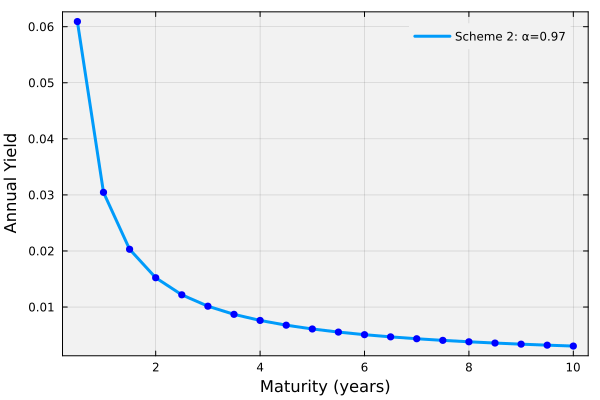

In [ ]:
let
    plot(strips_table_data_array_S2[1:end-1,2], strips_table_data_array_S2[1:end-1,5],lw=3,
        label="Scheme 2: α=$(α)")
    scatter!(strips_table_data_array_S2[1:end-1,2], strips_table_data_array_S2[1:end-1,5], 
        label="", msc="blue", mc="blue")
    xlabel!("Maturity (years)",fontsize=18)
    ylabel!("Yield to Maturity (spot rate)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

#### Check: How much do we collect from the sale of the STRIPS?
In this scenario, we purchased an original instrument from the [United States Treasury](https://www.treasurydirect.gov/) for $V_{B}$, stripped the coupons and face, and resold them. How much did we make from the sale of the resale of the STRIPS?

In [17]:
let
    nominal_computed_price = nominal_bond_model.price;
    resale_total = sum(strips_table_data_array_S2[:,4]);
    println("Purchased bond for $(nominal_computed_price) USD and stripped it for $(resale_total) USD")
end

Purchased bond for 99.10821833362596 USD and stripped it for 107.9125 USD


#### Summary Scheme 2 Pricing
* The constant discount (Scheme 2) pricing approach gives an inverted yield curve. Under pricing scheme 2, short-maturity `zeros` yield more than longer-maturity bonds.
* The observed yield $\bar{r}$ is inversely proportional to the value of the escalation parameter $\alpha$; smaller values of $\alpha$ lead to higher yields $\bar{r}$. On the other hand, under this scheme, the discount is constant.
* The yield we collect from the U.S. Treasury is less than what we pay to holders of the STRIPS products for short-maturity products. However, we pay significantly less than the Treasury for longer-duration products. 

### Scheme 3: Varying yield STRIPS
Fill me in.

In [18]:
θ₁, θ₂, β = 0.015, 0.001, 0.5; # parameters for scheme 3

Fill me in

In [19]:
strips_S3 = let

    strips = VLQuantitativeFinancePackage.strip(nominal_bond_model);
    discount_model = ContinuousCompoundingModel(); # Super interesting, this is what was needed to replicate the JPMorgan data!
    number_of_strips = length(strips);
    for (k,v) ∈ strips

        # get data from this strip
        model = v;
        T = model.T # time to maturity
        Vₚ = model.par; # face value
        r̄ = θ₁ + θ₂*(k-1)^β; # set the rate

        model.rate = r̄
        model |> discount_model; # set the model
        strips[k] = model; # update
    end
    strips; # return
end;

In [20]:
strips_S3

Dict{Int64, MyUSTreasuryZeroCouponBondModel} with 21 entries:
  5  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.017, 2.5, 0.539095, 2, Dict(0…
  16 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.018873, 8.0, 0.483672, 2, Dic…
  20 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0193589, 10.0, 0.463498, 2, D…
  12 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0183166, 6.0, 0.503957, 2, Di…
  8  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0176458, 4.0, 0.524166, 2, Di…
  17 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.019, 8.5, 0.478612, 2, Dict(0…
  1  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.015, 0.5, 0.558297, 2, Dict(0…
  19 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0192426, 9.5, 0.468523, 2, Di…
  6  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0172361, 3.0, 0.534153, 2, Di…
  11 => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0181623, 5.5, 0.509026, 2, Di…
  9  => MyUSTreasuryZeroCouponBondModel(0.5625, 0.0178284, 4.5, 0.519135, 2, Di…
  14 => MyUSTreasuryZeroCouponBondModel(0.5625,

#### Check: Visualize the first $m$ STRIPS products
`Unhide` the next code cell to see how we build a table displaying the bond price information. 
* First, specify the `number_of_strips_to_view.` Then, we'll loop through each STRIP and access the respective models from the `strips` dictionary using the bracket notation `strips[i],` where `i` represents the STRIP index. 
* Next, we'll add pricing, maturity, etc. data to the `strips_table_data_array` and display the resulting table by calling the `pretty_table(…)` function, which is exported by the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [21]:
strips_table_data_array_S3 = let

    number_of_strips = length(strips_S3);
    number_of_strips_to_view = number_of_strips ≥ 20 ? 10 : number_of_strips
    strips_table_data_array = Array{Any,2}(undef, number_of_strips, 6);
    strips_table_header_array = (["", "Maturity","Face","Price","r̄", "Discount"],
        ["","YR","USD","USD","", "price/face"]);
    for i ∈ 1:number_of_strips

        zc_model = strips_S3[i];
        strips_table_data_array[i,1] = i
        strips_table_data_array[i,2] = zc_model.T
        strips_table_data_array[i,3] = zc_model.par
        strips_table_data_array[i,4] = zc_model.price
        strips_table_data_array[i,5] = zc_model.rate  
        strips_table_data_array[i,6] = (zc_model.price/zc_model.par)
    end
    pretty_table(strips_table_data_array[1:number_of_strips_to_view,1:end], 
        header=strips_table_header_array, tf = tf_simple)

    strips_table_data_array; # return
end;

===== ========== ======== ========== =========== =============
       Maturity     Face      Price           r̄     Discount 
             YR      USD        USD               price/face 
===== ========== ======== ========== =========== =============
   1        0.5   0.5625   0.558297       0.015     0.992528
   2        1.0   0.5625   0.553572       0.016     0.984127
   3        1.5   0.5625    0.54882   0.0164142     0.975679
   4        2.0   0.5625   0.543988   0.0167321      0.96709
   5        2.5   0.5625   0.539095       0.017      0.95839
   6        3.0   0.5625   0.534153   0.0172361     0.949606
   7        3.5   0.5625   0.529174   0.0174495     0.940754
   8        4.0   0.5625   0.524166   0.0176458      0.93185
   9        4.5   0.5625   0.519135   0.0178284     0.922906
  10        5.0   0.5625   0.514086       0.018     0.913931
===== ========== ======== ========== =========== =============


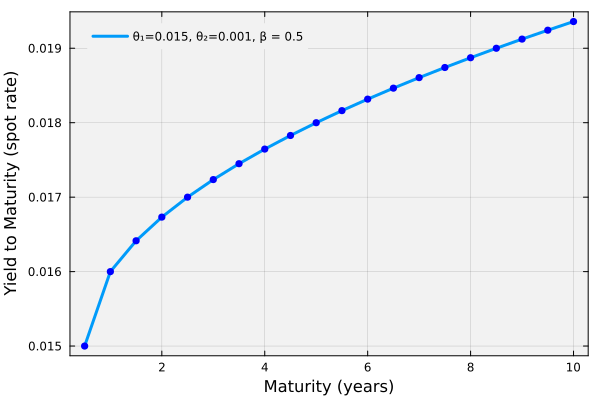

In [ ]:
let

    plot(strips_table_data_array_S3[1:end-1,2], strips_table_data_array_S3[1:end-1,5],lw=3,
    label="θ₁=$(θ₁), θ₂=$(θ₂), β = $(β)")
    scatter!(strips_table_data_array_S3[1:end-1,2], strips_table_data_array_S3[1:end-1,5], 
    label="", msc="blue", mc="blue")
    xlabel!("Maturity (years)",fontsize=18)
    ylabel!("Yield to Maturity (spot rate)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

#### Check: How much do we collect from the sale of the STRIPS?
In this scenario, we purchased an original instrument from the [United States Treasury](https://www.treasurydirect.gov/) for $V_{B}$, stripped the coupons and face, and resold them. How much did we make from the sale of the STRIPS?

In [23]:
let
    nominal_computed_price = nominal_bond_model.price;
    resale_total = sum(strips_table_data_array_S3[:,4]);
    println("Purchased bond for $(nominal_computed_price) USD and stripped it for $(resale_total) USD")
end

Purchased bond for 99.10821833362596 USD and stripped it for 92.53316703878286 USD


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.